<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Data-Analysis-And-Machine-Learning-Projects/blob/master/9.%20Time%20Series%20And%20Forecasting/Electricity%20Consumption%20Analysis%20%5BTime-Series%5D/Electricity_Consumption_Diagrams_(2011_2014)_Forecasting_%26_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Download Dataset <a id=1></a>

In [ ]:
!wget https://archive.ics.uci.edu/static/public/321/electricityloaddiagrams20112014.zip
!unzip /content/electricityloaddiagrams20112014.zip

[Dataset Source](https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014)

# 2. Import Libraries <a id=2></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.signal import find_peaks
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer


## 2.1 Import Dataset <a id=2.1></a>

In [4]:
df = pd.read_csv("/content/LD2011_2014.txt", sep=";", index_col='Unnamed: 0')

In [5]:
print(df.index.min())
print(df.index.max())

2011-01-01 00:15:00
2015-01-01 00:00:00


In [23]:
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [24]:
df.dtypes

,0
MT_001,object
MT_002,object
MT_003,object
MT_004,object
MT_005,object
...,...
MT_366,object
MT_367,object
MT_368,object
MT_369,object


# 3. Preprocessing <a id=3></a>

## 3.1 Correcting Dtype <a id=3.1></a>

In [34]:
def convert_to_float(value):
    try:
        # Handle European number formatting
        return float(str(value).replace(',', '.'))
    except (ValueError, AttributeError) as e:
        # Log the error and the value causing it
        return np.nan

In [35]:
# Apply the function to all object columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].apply(convert_to_float)

In [38]:
df

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


## 3.2 Handling Missing Values <a id=3.2></a>

In [52]:
# df2 -> NaNs dropped
# df2 = df.dropna(axis=1)
# df2.head()

In [53]:
# Backward fill
# df_bfill = df.fillna(method='bfill', axis=1)

In [39]:
# df_bfill = df_bfill.dropna(axis=1)
# df_bfill.head()

## 3.4 Adjust Datetime <a id=3.4></a>

In [40]:
df.index = pd.to_datetime(df.index)

All time labels report to Portuguese hour. However all days present 96 measures (24*4). Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points. Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.

In [41]:
# Function to adjust time change days
def adjust_time_change(df):
    # March time change day (23 hours)
    march_time_change = df.index[df.index.month == 3]
    for date in march_time_change:
        if date.hour == 1 and date.minute == 0:
            df.loc[date] = 0

    # October time change day (25 hours)
    october_time_change = df.index[df.index.month == 10]
    for date in october_time_change:
        if date.hour == 1 and date.minute == 0:
            df.loc[date] = df.loc[date] + df.loc[date + pd.Timedelta(hours=1)]
            df.loc[date + pd.Timedelta(hours=1)] = 0

    return df

In [42]:
df = adjust_time_change(df)
# df2 = adjust_time_change(df2)
# df_bfill = adjust_time_change(df_bfill)

In [45]:
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.3 Convert to kW/h <a id=3.3></a>

Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.


In [44]:
# Ensure the index is a DatetimeIndex
df.index = pd.date_range(start='2011-01-01 00:15:00', periods=len(df), freq='15T')

# Convert values from kW to kWh
df = df / 4

# Resample the data to an hourly frequency
hourly_df = df.resample('H').sum()

# 4. EDA <a id=4></a>

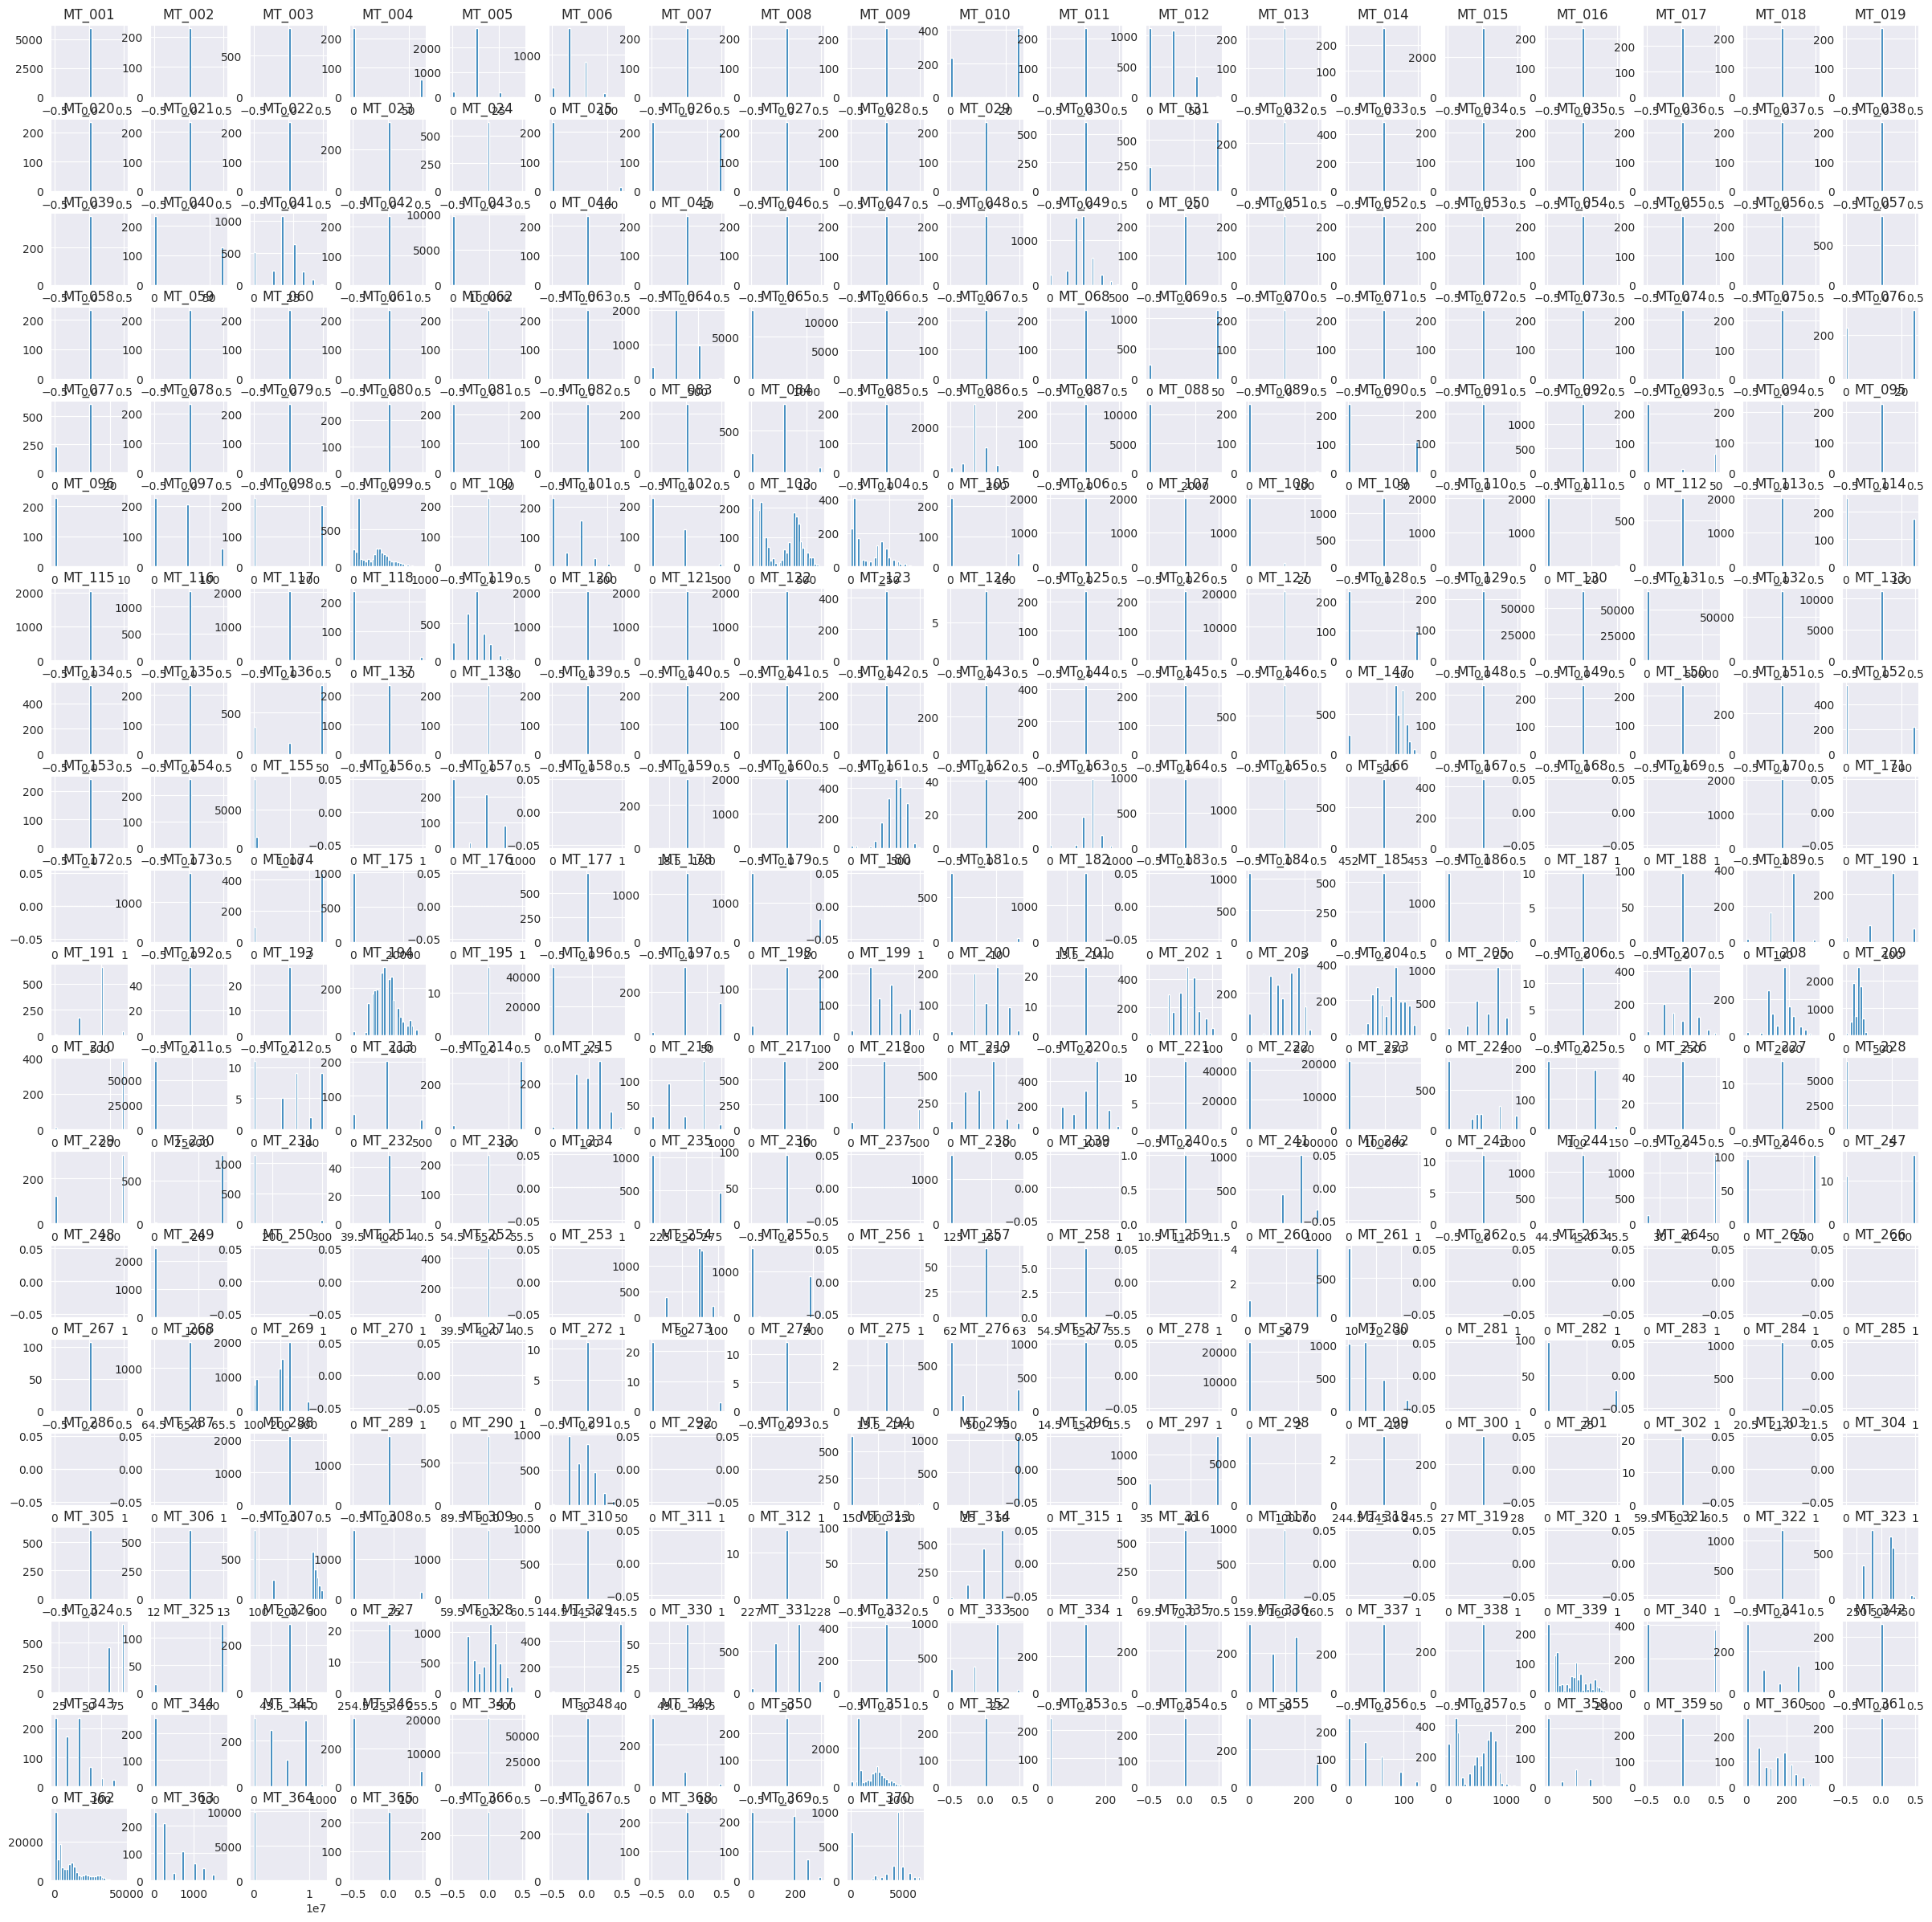

In [64]:
df.hist(bins=30, figsize=(30, 30))
plt.show()

## 4.1 Visualize Individual Client Time Series <a id=4.1></a>

In [56]:
def plot_client(dataframe, client_id):
    """
    Plot the time series data for a specific client.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        The DataFrame containing the time series data for various clients.
        The index should represent the time dimension, and the columns should
        represent individual clients' consumption data.
    client_id : str or int
        The identifier for the client whose time series data will be plotted.
        This should correspond to a column name in the DataFrame.

    Returns:
    --------
    None
        The function generates and displays a plot but does not return any value.

    Example:
    --------
    >>> plot_client(dataframe=df, client_id='Client_123')
    Displays a time series plot for 'Client_123'.

    Notes:
    ------
    - Ensure the DataFrame has a datetime-like index and the client_id exists
      as a column in the DataFrame.
    - The y-axis represents the client's consumption (in kWh), while the x-axis
      represents time.
    """
    plt.figure(figsize=(20, 5))
    sns.set_style('dark')
    plt.plot(df.index,
             df[client_id],
             label=client_id,
             color='darkblue')
    plt.title(f'Time Series for Client {client_id}', fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=10, fontweight='bold')
    plt.ylabel('Consumption (kWh)', fontsize=10, fontweight='bold')
    plt.legend()
    plt.show()

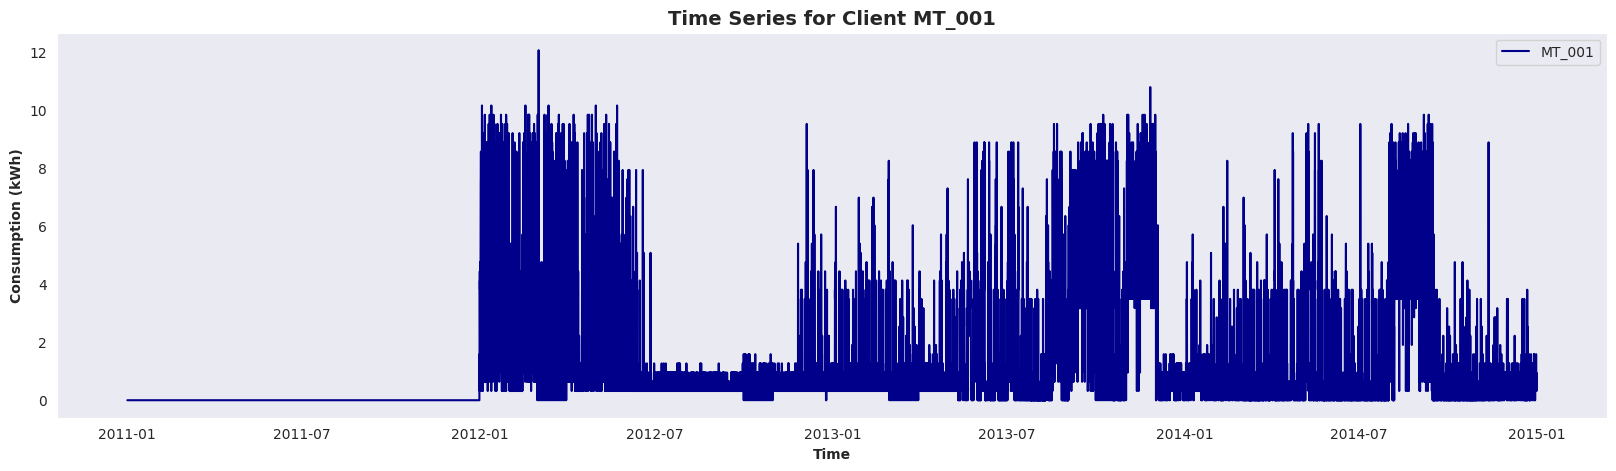

In [57]:
plot_client(df, 'MT_001')

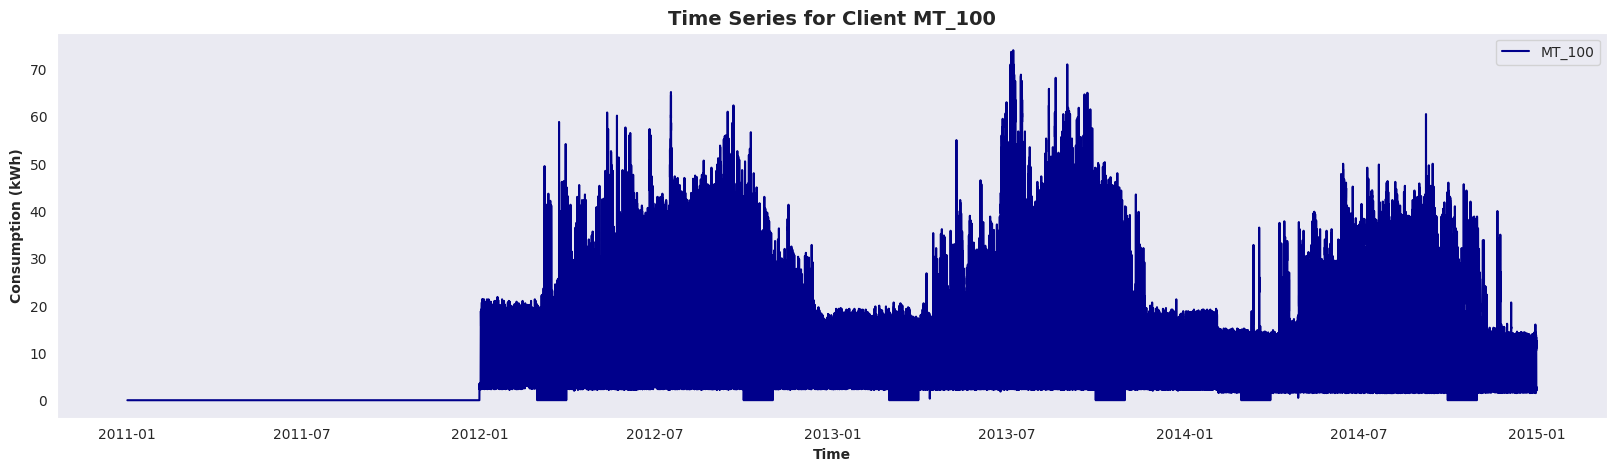

In [58]:
plot_client(df, 'MT_100')

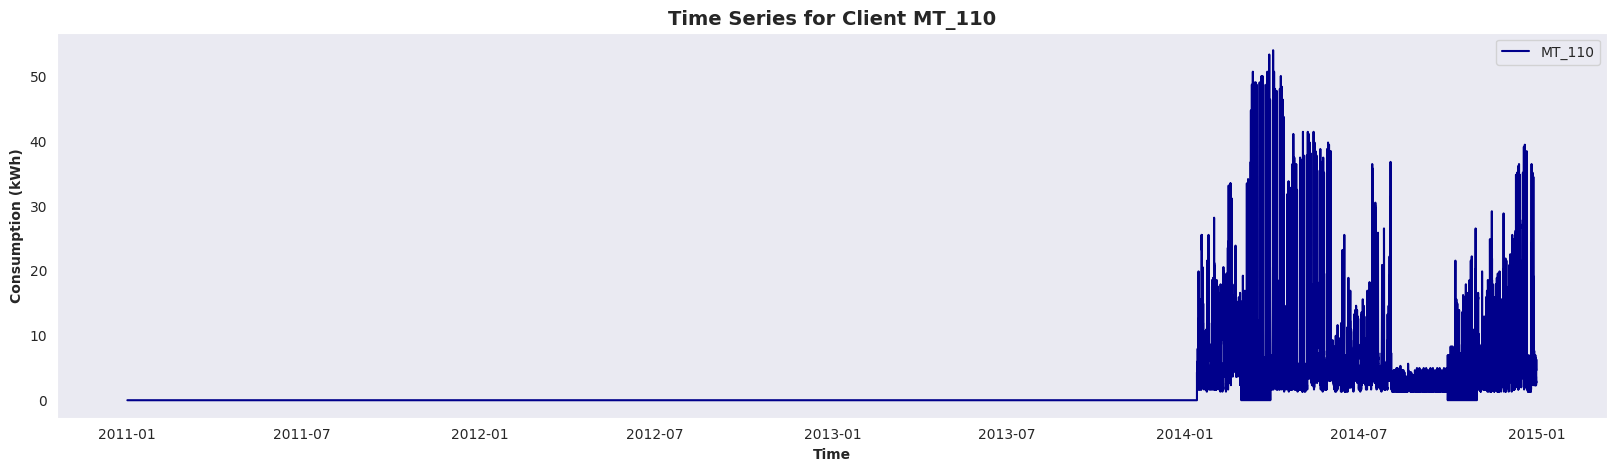

In [59]:
plot_client(df, 'MT_110')

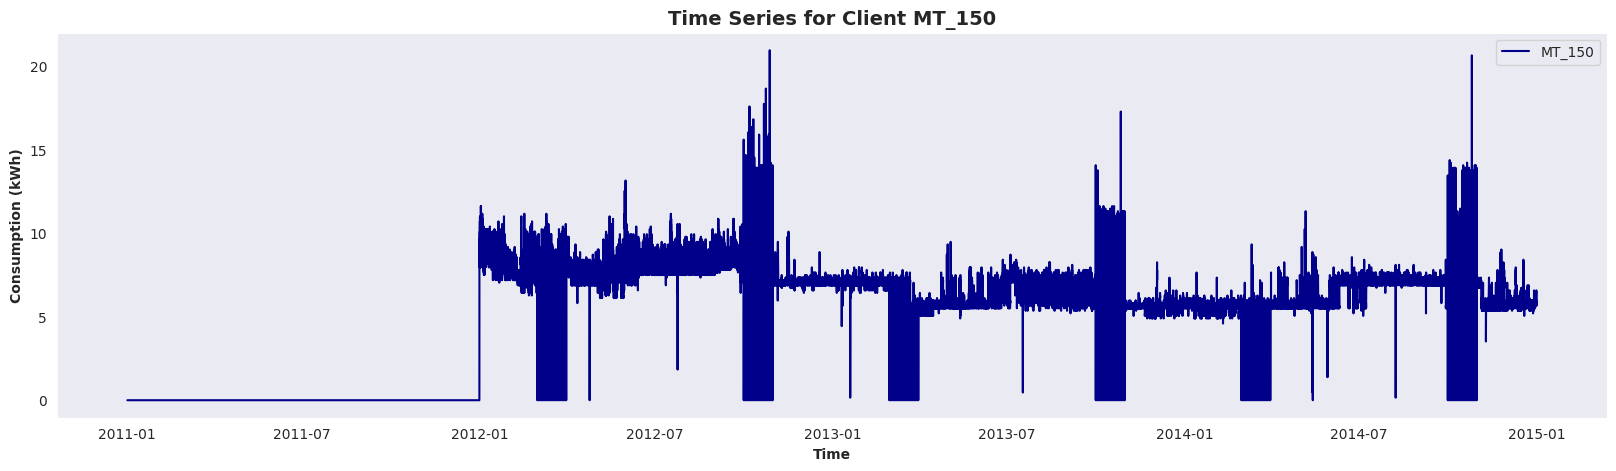

In [60]:
plot_client(df, 'MT_150')

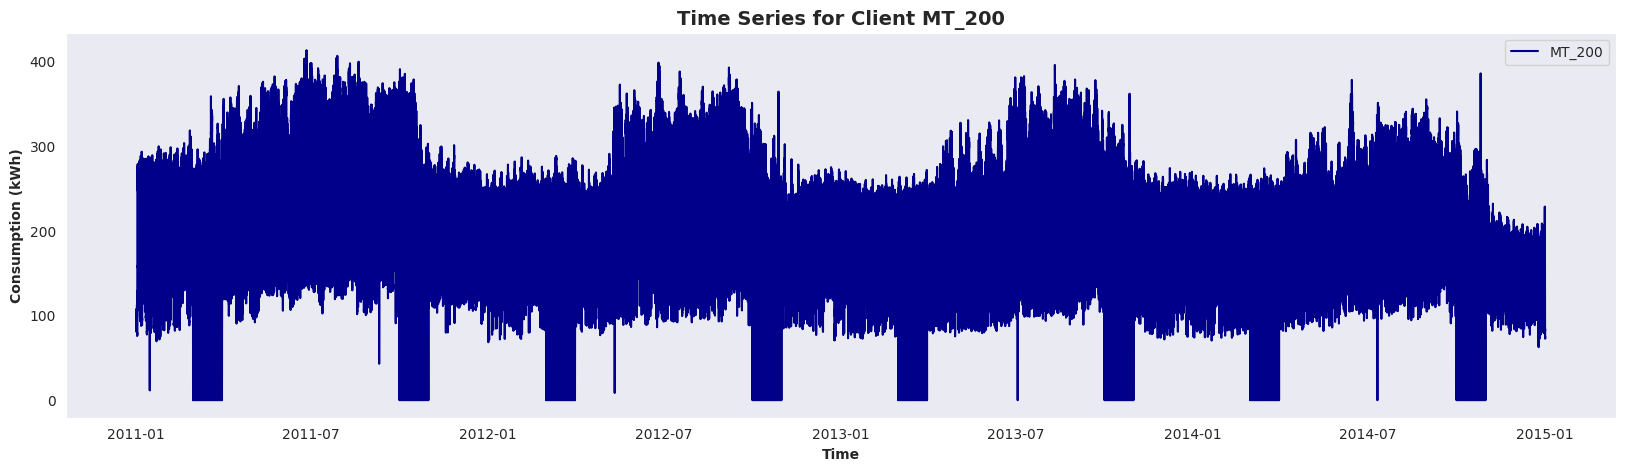

In [61]:
plot_client(df, 'MT_200')

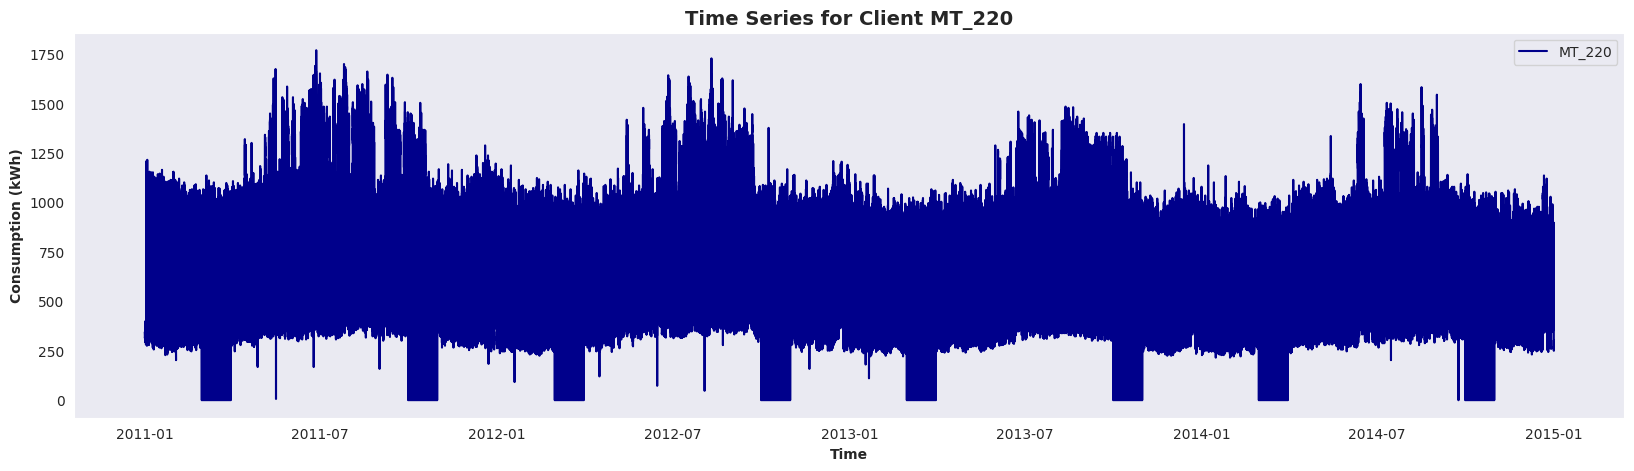

In [62]:
plot_client(df, 'MT_220')

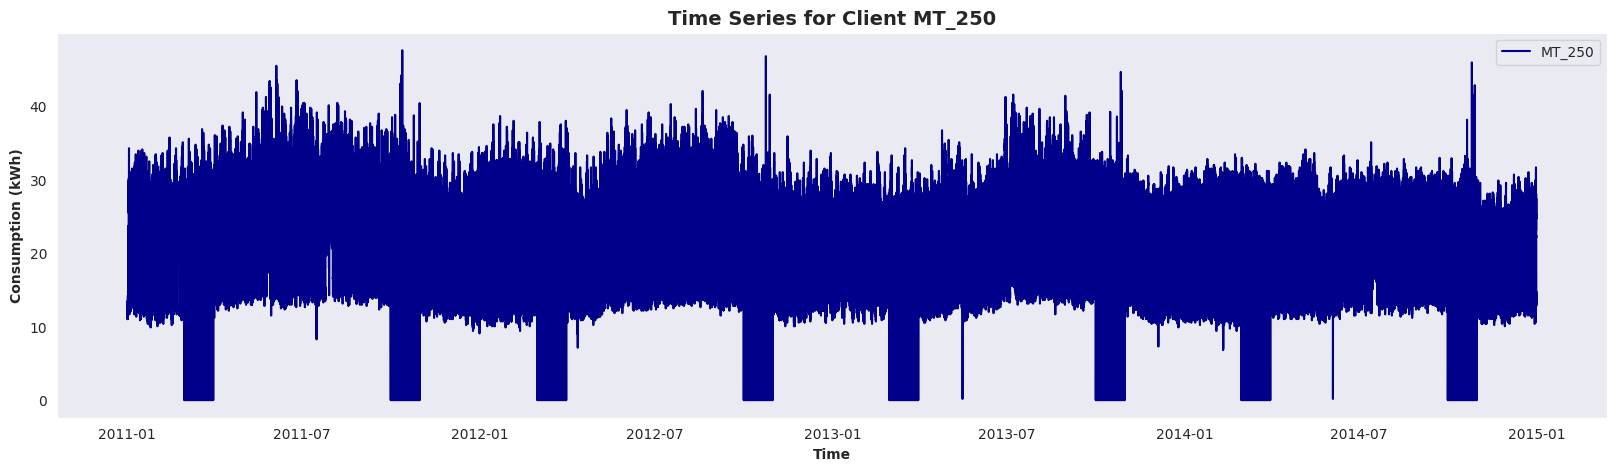

In [63]:
plot_client(df, 'MT_250')

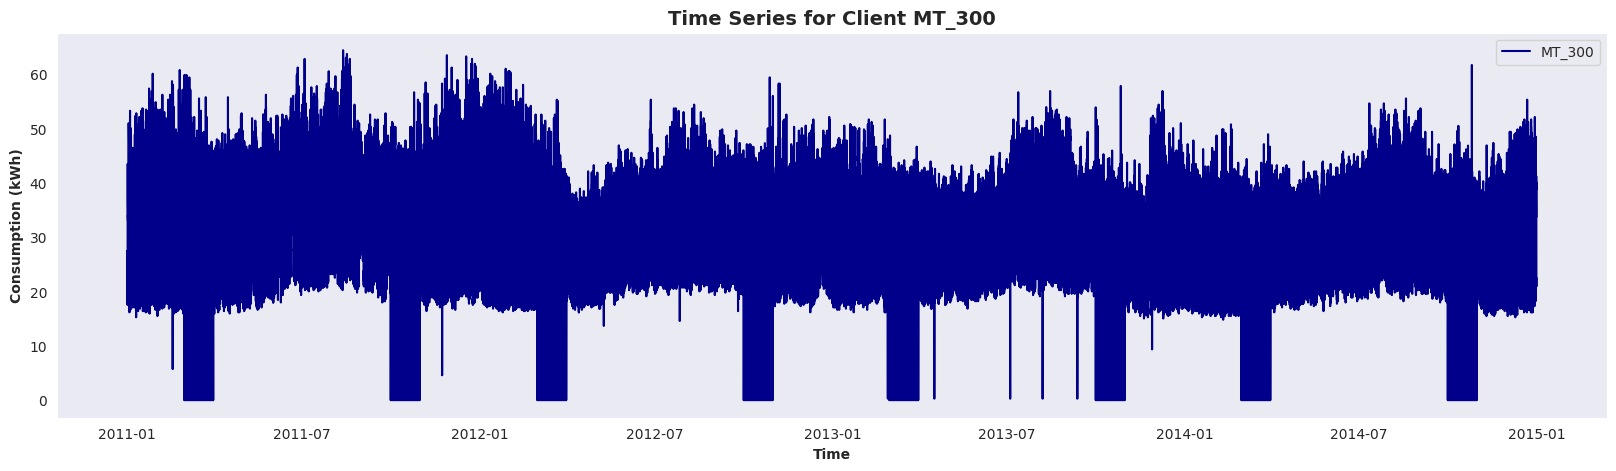

In [64]:
plot_client(df, 'MT_300')

## 4.2 Aggregate Consumption <a id=4.2></a>

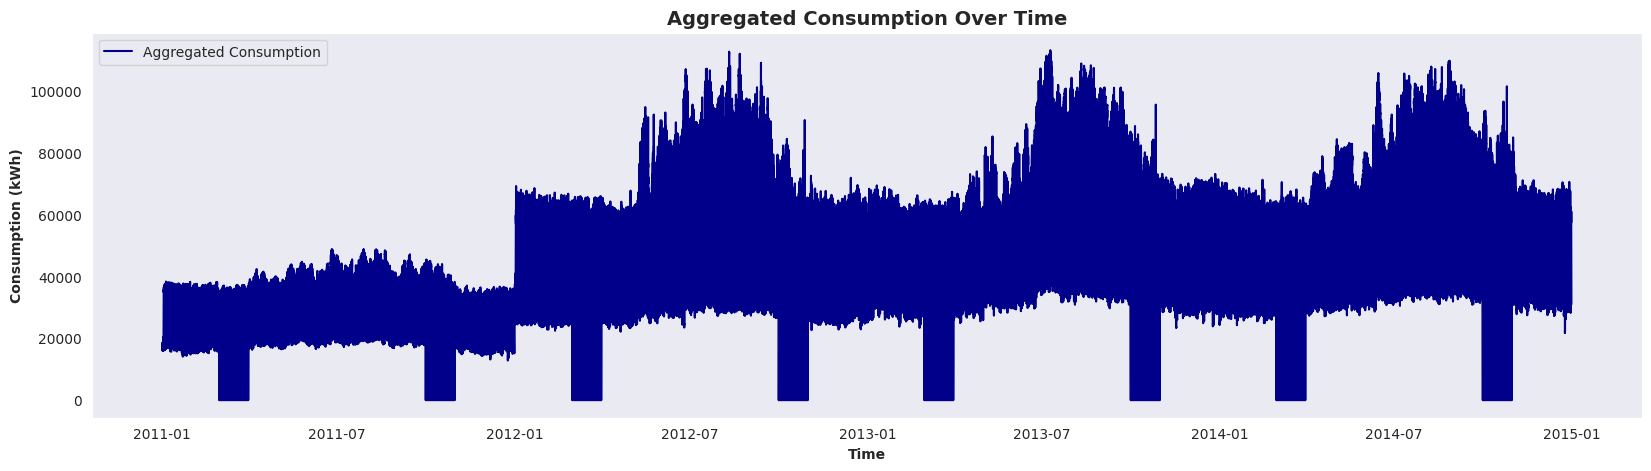

In [65]:
# Aggregate consumption across all clients
aggregated_consumption = df.sum(axis=1)

# Plot aggregated consumption
plt.figure(figsize=(20, 5))
plt.plot(df.index, aggregated_consumption, label='Aggregated Consumption', color='darkblue')
plt.title('Aggregated Consumption Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=10, fontweight='bold')
plt.ylabel('Consumption (kWh)', fontsize=10, fontweight='bold')
plt.legend()
plt.show()


## 4.3 Identify Trends <a id=4.3></a>

In [66]:
def plot_moving_average(df, window_size, client_column=None):
    """
    Plots the moving average of the aggregated consumption or a specific client's consumption.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the time series data.
    window_size (int): The window size for the moving average.
    client_column (str, optional): The column name of the client to analyze. If None, aggregated consumption is used.
    """
    if client_column:
        consumption = df[client_column]
        title = f'Time Series with Moving Average for Client {client_column}'
    else:
        consumption = df.sum(axis=1)
        title = 'Aggregated Consumption with Moving Average'

    # Calculate moving average
    moving_avg = consumption.rolling(window=window_size).mean()

    # Plot moving average
    plt.figure(figsize=(20, 5))
    plt.plot(df.index, consumption, label='Consumption')
    plt.plot(df.index, moving_avg, label='Moving Average', color='red')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=10, fontweight='bold')
    plt.ylabel('Consumption (kWh)', fontsize=10, fontweight='bold')
    plt.legend()
    plt.show()

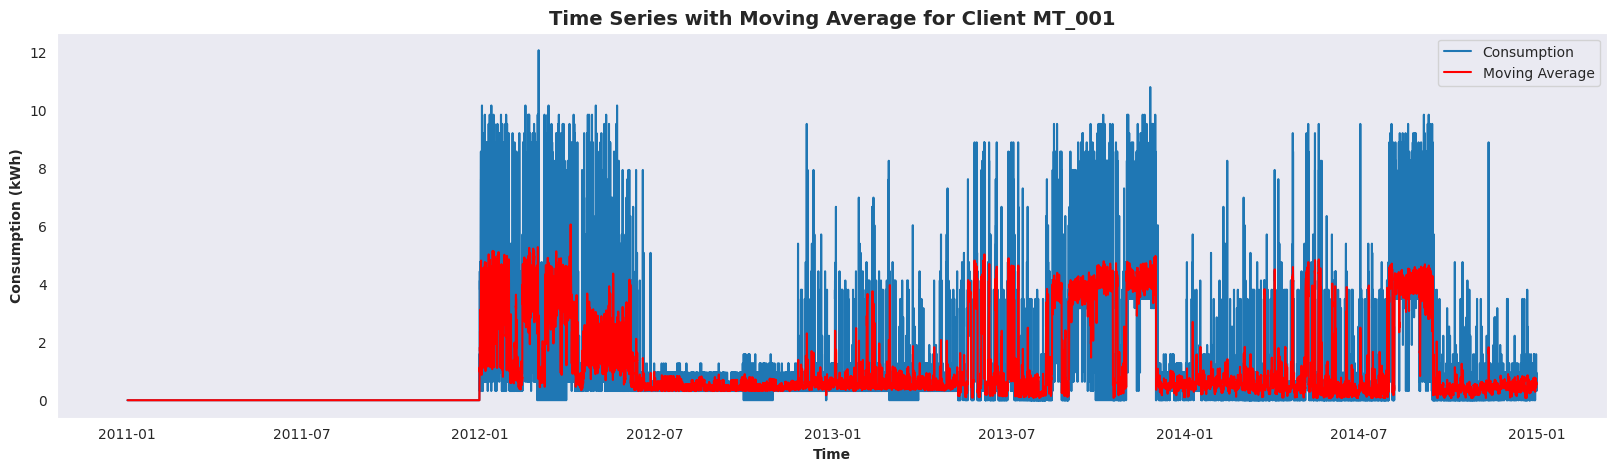

In [67]:
# Plot moving average for a specific client
plot_moving_average(df, window_size=24, client_column='MT_001')

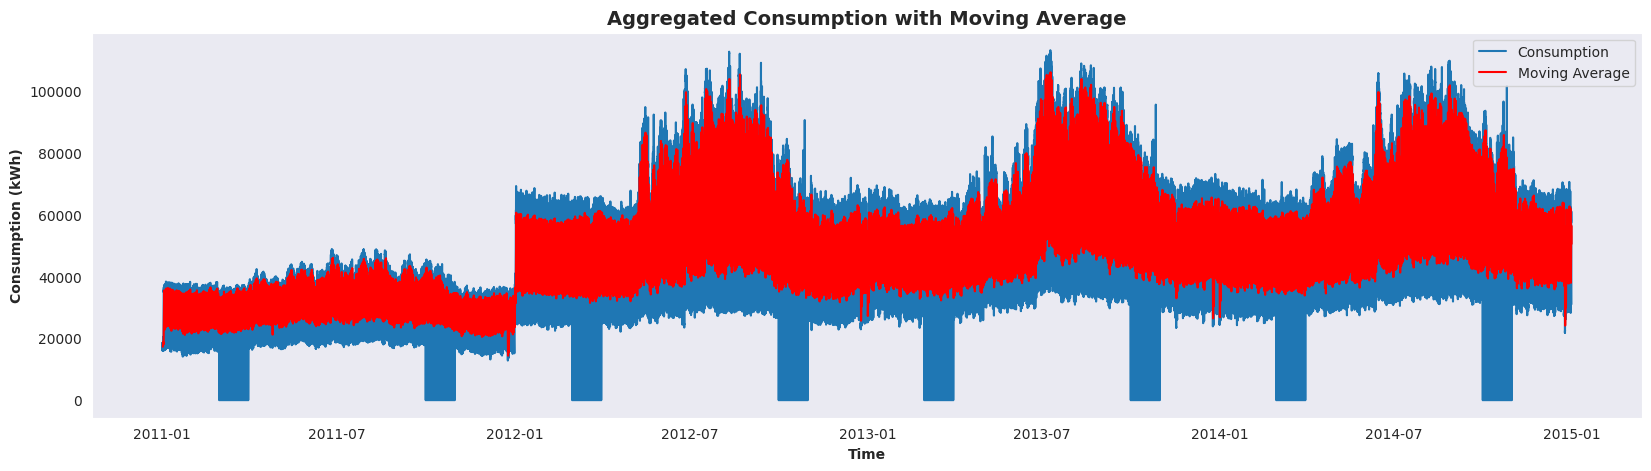

In [68]:
# Plot moving average for aggregated consumption
plot_moving_average(df, window_size=48)

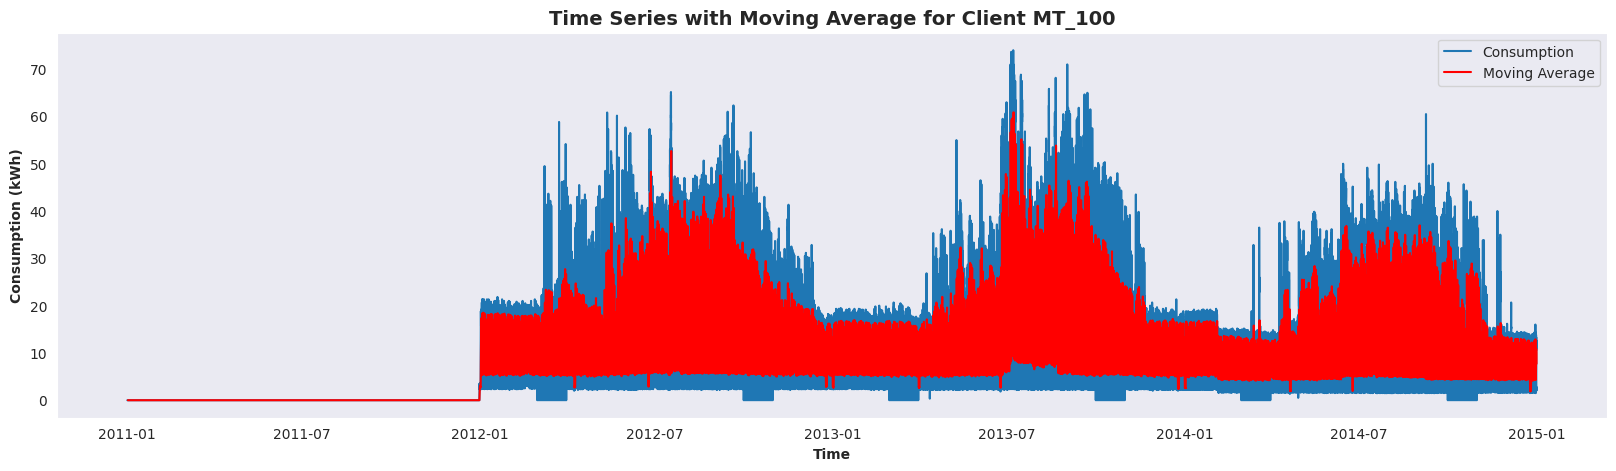

In [69]:
# Plot moving average for aggregated consumption
plot_moving_average(df, window_size=48, client_column='MT_100')

## 4.4 Detect Consumption Peaks <a id=4.5></a>

In [70]:
def plot_consumption_peaks(df, client_column=None):
    """
    Plots the consumption peaks for a specific client or the aggregated consumption.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the time series data.
    client_column (str, optional): The column name of the client to analyze. If None, aggregated consumption is used.
    """
    if client_column:
        consumption = df[client_column]
        title = f'Consumption Peaks for Client {client_column}'
    else:
        consumption = df.sum(axis=1)
        title = 'Aggregated Consumption with Peaks'

    # Find peaks in the consumption
    peaks, _ = find_peaks(consumption, height=consumption.mean())

    # Plot peaks
    plt.figure(figsize=(20, 5))
    plt.plot(df.index, consumption, label='Consumption')
    plt.plot(df.index[peaks], consumption[peaks], "x", label='Peaks')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=10, fontweight='bold')
    plt.ylabel('Consumption (kWh)', fontsize=10, fontweight='bold')
    plt.legend()
    plt.show()

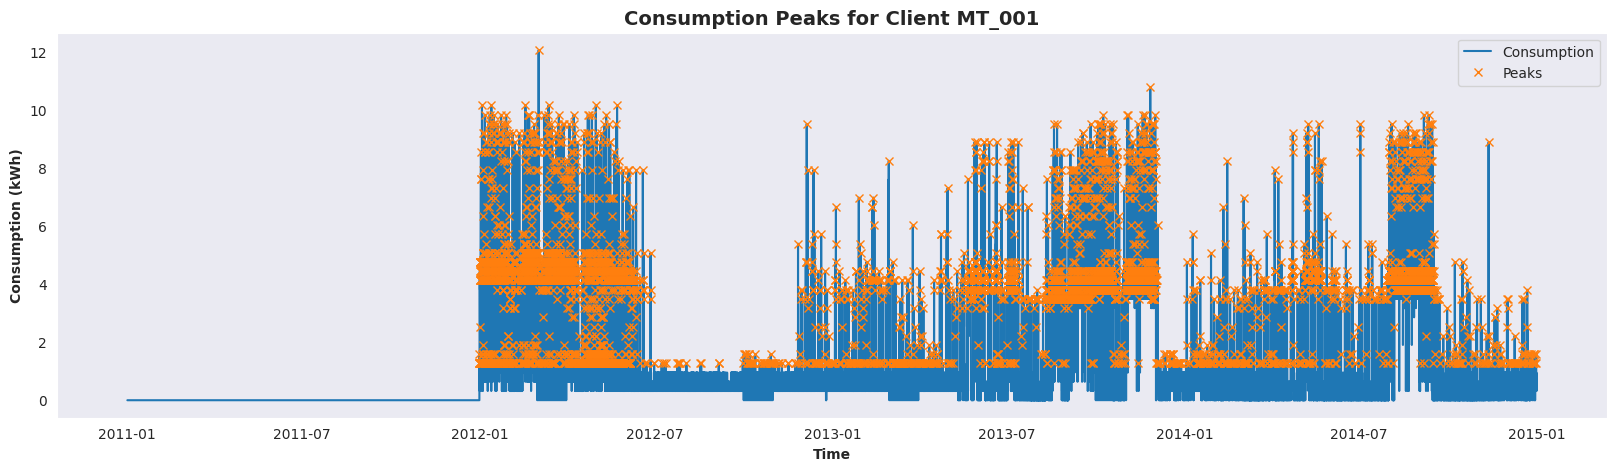

In [71]:
# Plot consumption peaks for a specific client
plot_consumption_peaks(df, client_column='MT_001')

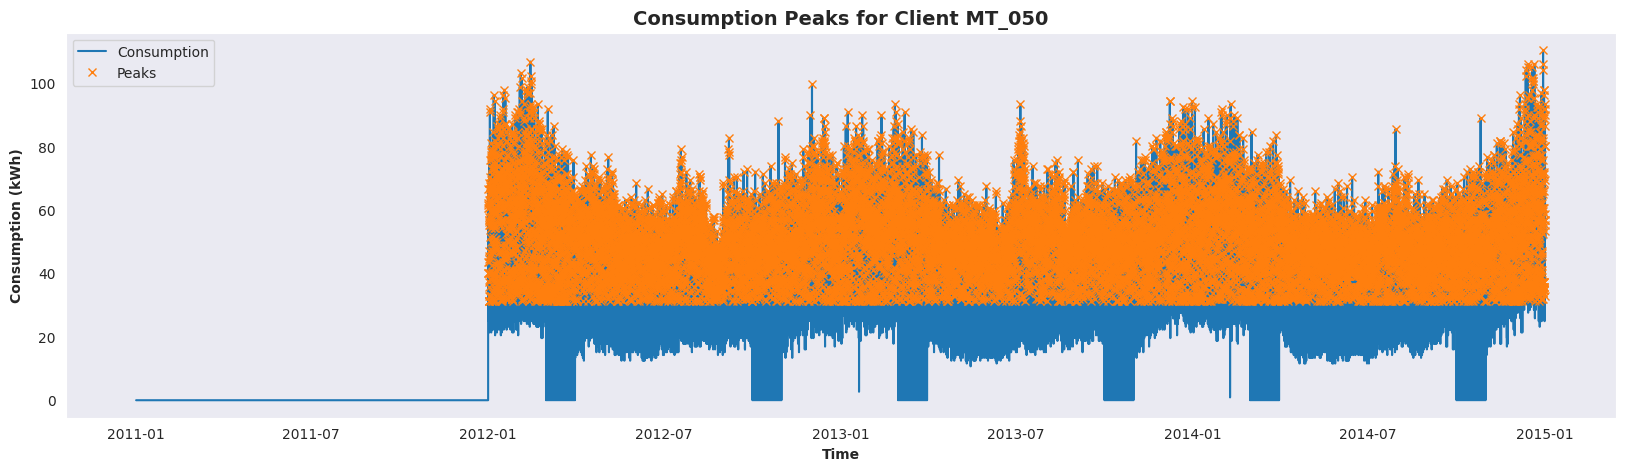

In [72]:
plot_consumption_peaks(df, client_column='MT_050')

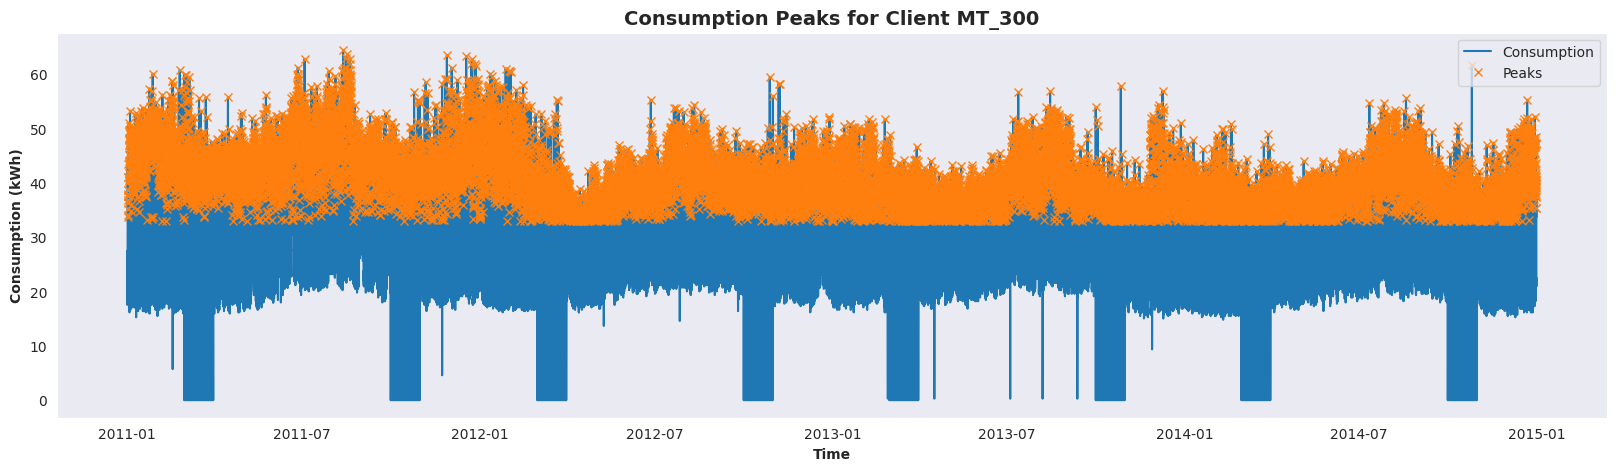

In [73]:
plot_consumption_peaks(df, client_column='MT_300')

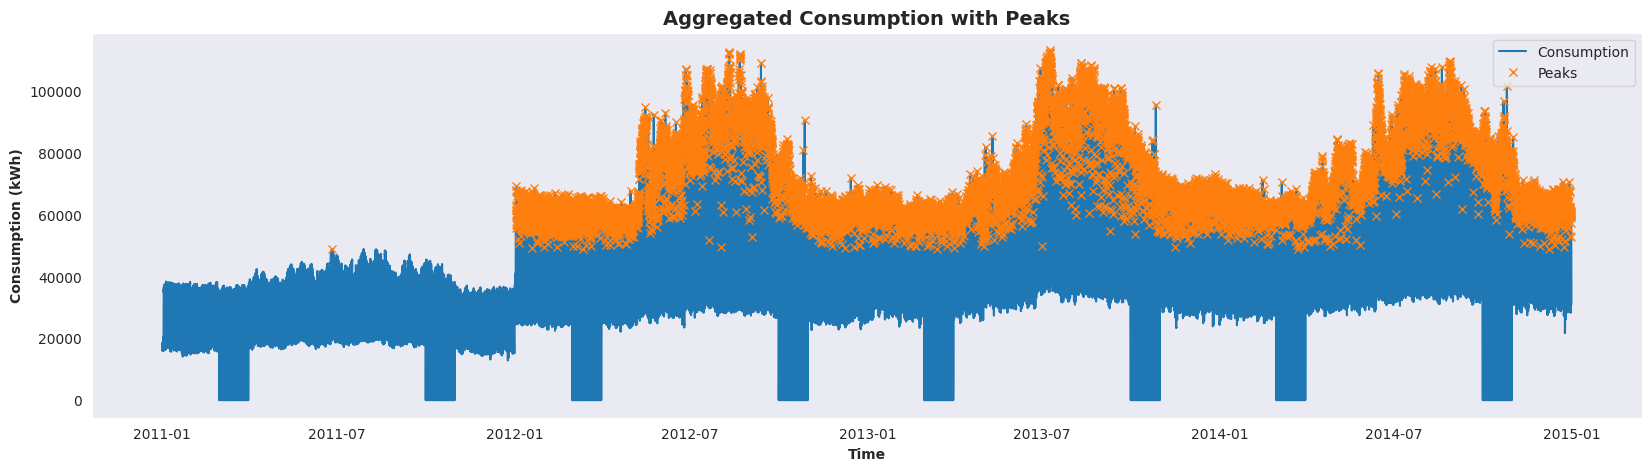

In [74]:
# Plot consumption peaks for aggregated consumption
plot_consumption_peaks(df)

## 4.5 Seasonal Decomposition <a id=4.6></a>

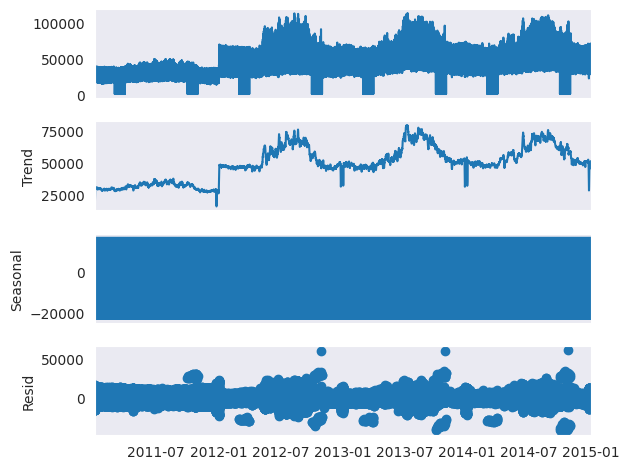

In [75]:
# Decompose the aggregated consumption
decomposition = seasonal_decompose(aggregated_consumption, model='additive', period=96)  # 96 periods per day
# Plot decomposition
decomposition.plot()
plt.show()

## 4.6 Weekly & Daily Consumption <a id=4.7></a>

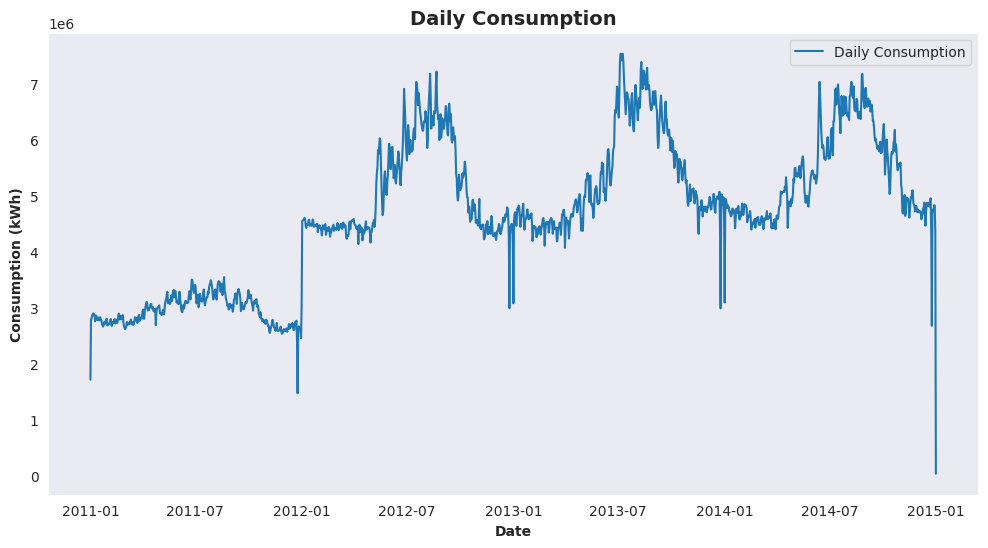

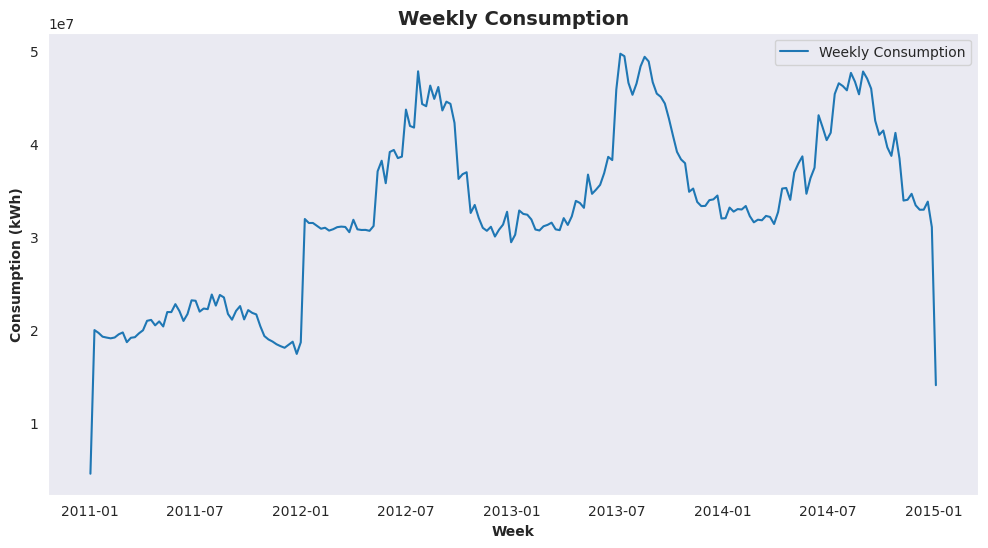

In [76]:
# Resample data to daily and weekly frequency
daily_consumption = aggregated_consumption.resample('D').sum()
weekly_consumption = aggregated_consumption.resample('W').sum()

# Plot daily consumption
plt.figure(figsize=(12, 6))
plt.plot(daily_consumption.index, daily_consumption, label='Daily Consumption')
plt.title('Daily Consumption', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=10, fontweight='bold')
plt.ylabel('Consumption (kWh)', fontsize=10, fontweight='bold')
plt.legend()
plt.show()

# Plot weekly consumption
plt.figure(figsize=(12, 6))
plt.plot(weekly_consumption.index, weekly_consumption, label='Weekly Consumption')
plt.title('Weekly Consumption', fontsize=14, fontweight='bold')
plt.xlabel('Week', fontsize=10, fontweight='bold')
plt.ylabel('Consumption (kWh)', fontsize=10, fontweight='bold')
plt.legend()
plt.show()

In [77]:
def plot_resampled_consumption(df, frequency, client_column=None):
    """
    Plots the resampled consumption for a specific client or the aggregated consumption.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the time series data.
    frequency (str): The resampling frequency (e.g., 'D' for daily, 'W' for weekly).
    client_column (str, optional): The column name of the client to analyze. If None, aggregated consumption is used.
    """
    if client_column:
        consumption = df[client_column]
        title = f'Resampled Consumption for Client {client_column}'
    else:
        consumption = df.sum(axis=1)
        title = f'Aggregated Consumption Resampled to {frequency}'

    # Resample data
    resampled_consumption = consumption.resample(frequency).sum()

    # Plot resampled consumption
    plt.figure(figsize=(12, 6))
    plt.plot(resampled_consumption.index, resampled_consumption, label=f'{frequency} Consumption')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=10, fontweight='bold')
    plt.ylabel('Consumption (kWh)', fontsize=10, fontweight='bold')
    plt.legend()
    plt.show()

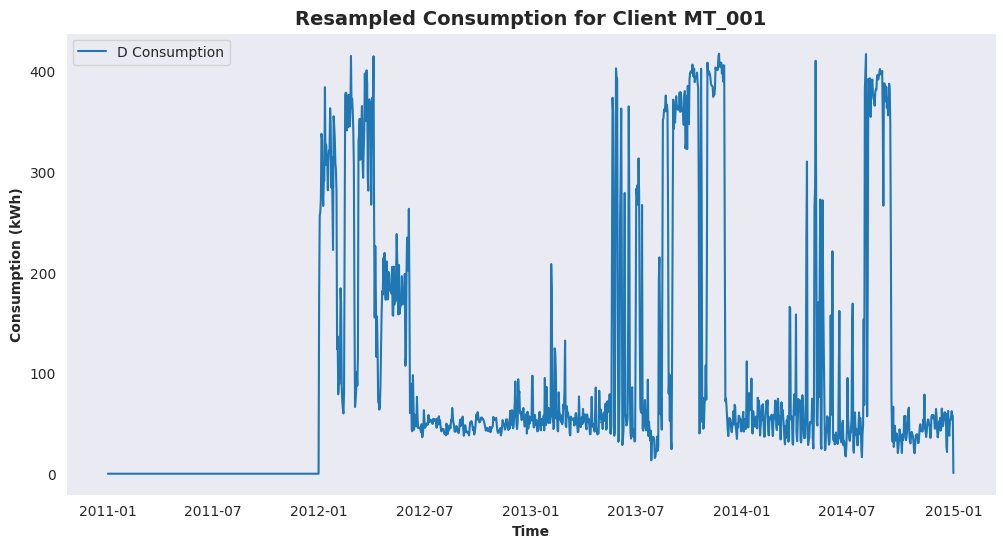

In [78]:
# Plot daily consumption for a specific client
plot_resampled_consumption(df, frequency='D', client_column='MT_001')

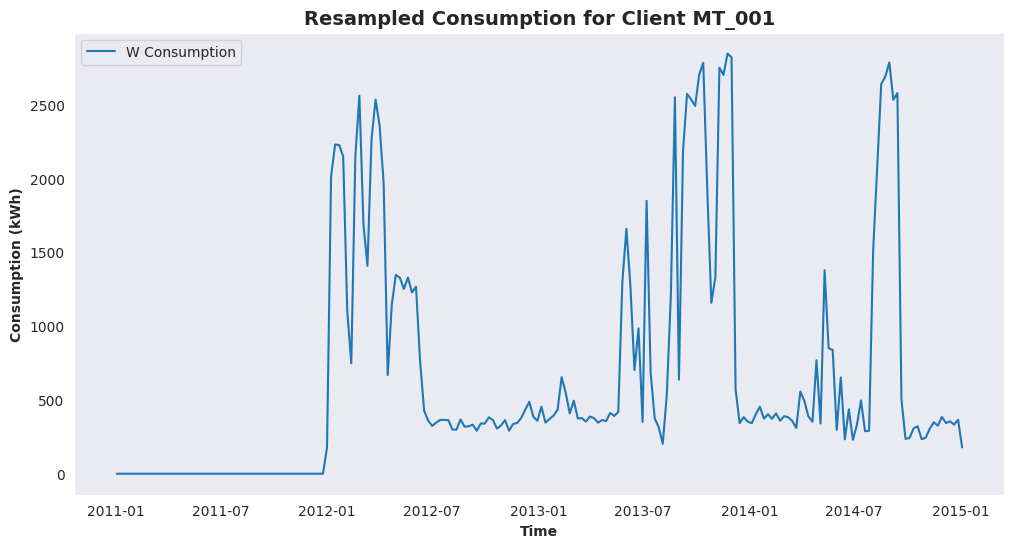

In [79]:
plot_resampled_consumption(df, frequency='W', client_column='MT_001')

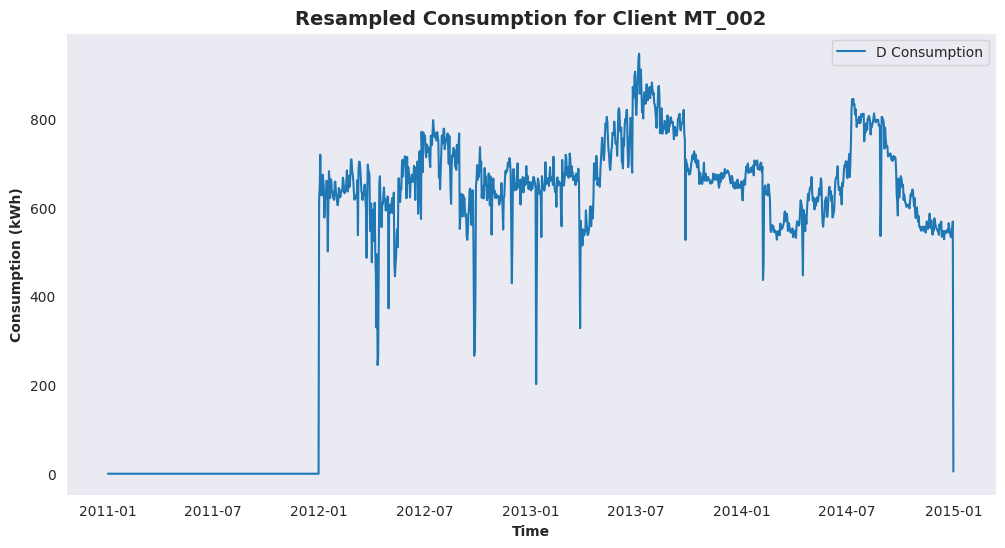

In [80]:
plot_resampled_consumption(df, frequency='D', client_column='MT_002')

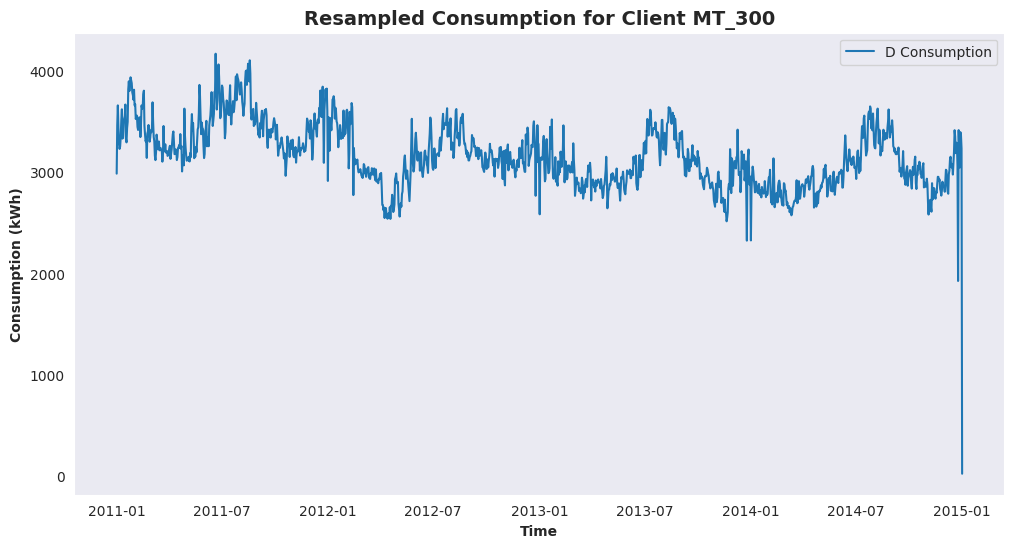

In [81]:
plot_resampled_consumption(df, frequency='D', client_column='MT_300')

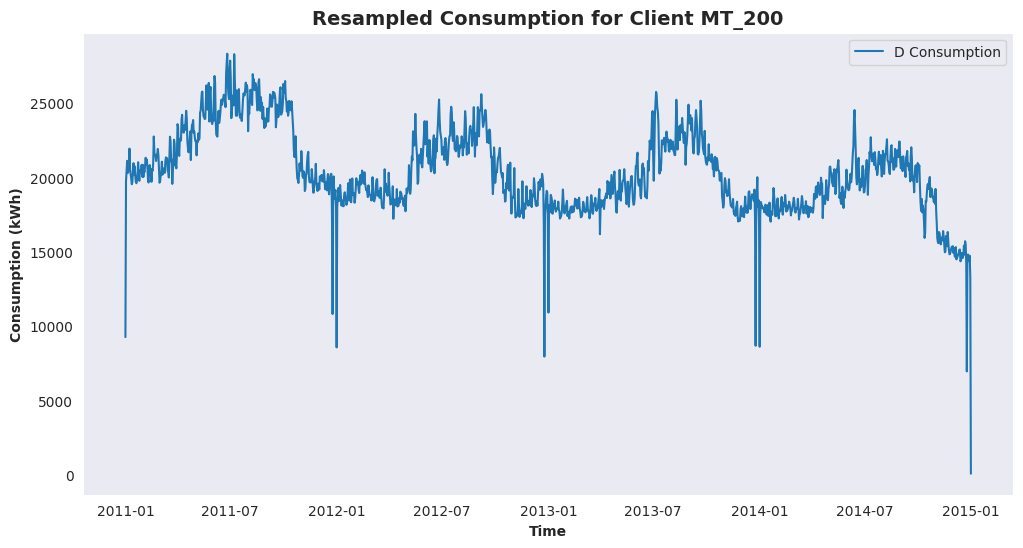

In [82]:
plot_resampled_consumption(df, frequency='D', client_column='MT_200')

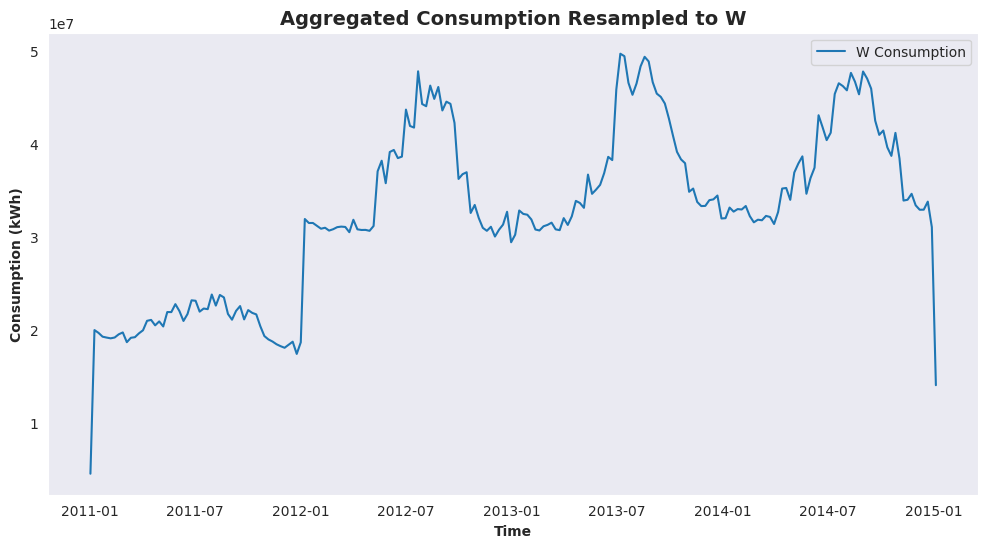

In [83]:
# Plot weekly consumption for aggregated consumption
plot_resampled_consumption(df, frequency='W')

## 4.7 Anomalies in Consumption <a id=4.8></a>

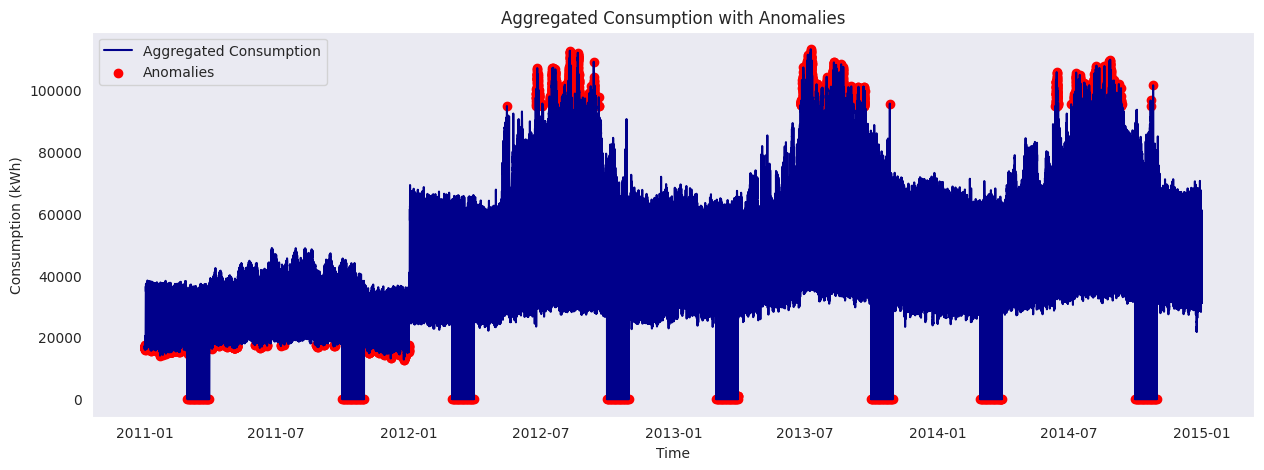

In [85]:
# Train Isolation Forest model
iso_forest = IsolationForest(contamination=0.05)  # Adjust contamination level as needed
anomalies = iso_forest.fit_predict(aggregated_consumption.values.reshape(-1, 1))

# Plot anomalies
plt.figure(figsize=(15, 5))
plt.plot(df.index, aggregated_consumption, label='Aggregated Consumption', color='darkblue')
plt.scatter(df.index[anomalies == -1], aggregated_consumption[anomalies == -1], color='red', label='Anomalies')
plt.title('Aggregated Consumption with Anomalies')
plt.xlabel('Time')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

## 4.8 Autocorrelation and Partial Autocorrelation <a id=4.8></a>

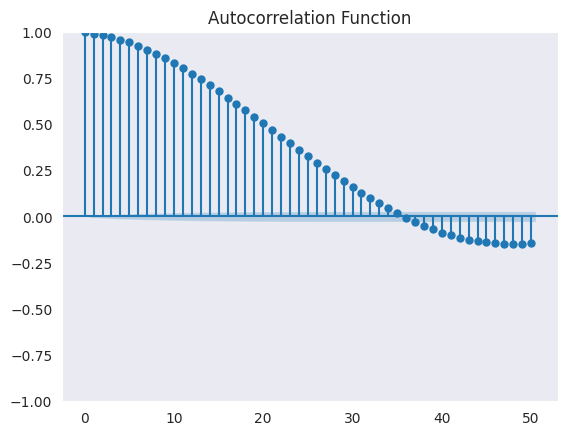

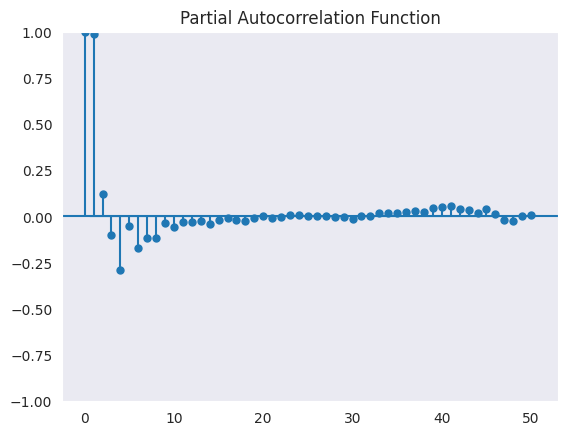

In [86]:
# Plot autocorrelation
plot_acf(aggregated_consumption, lags=50)
plt.title('Autocorrelation Function')
plt.show()

# Plot partial autocorrelation
plot_pacf(aggregated_consumption, lags=50)
plt.title('Partial Autocorrelation Function')
plt.show()
